# GEO3463: CTD data processing code for SAMS field trip Day 2 (25/05/23)
This Jupyter program is used to read and plot the CTD data, including, 
1. CTD profile data

Variables and definations in CTD
- Scan: Scan Count [dimensionless]
- DepSM: Depth [m]
- prDM: Pressure, Digiquartz [db]
- Tv290C: Temperature [deg C]
- C0mS/cm: Conductivity [mS/cm]
- FlECO-AFL: fluorescence [mg/m3] 
- Par/sat/log: PAR [uE/m2/s] 
- Sbeox0Mm/L: Oxygen [umol/L]
- Sbeox0PS: O2 saturation [%] 
- DepSM2: Depth [m]
- Sal00: Salinity [PSU]
- Sigma-t00: Density [kg/m3]
- SvCM: Sound Velocity [m/s]

Definition of parameters in CTD
-  https://www.bco-dmo.org/dataset/3911
-  https://www.bco-dmo.org/dataset-deployment/701433
-  https://www.bco-dmo.org/dataset/3387
-  https://www.bco-dmo.org/dataset-instrument/5558

Code written by Xuerong Sun, adapted by Bob Brewin

### Load function needed for the program

In [1]:
import openpyxl
import math
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import glob
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Supress warnings (prevents Jupyter printing out warnings....do be careful with this)

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Read log file to get the lat and lon, there is no position info in the CTD file

In [3]:
creran_log = pd.read_excel('cruise_data_lat_lon_creran.xlsx')
creran_log_lat_lon = creran_log[['lat_dec','lon_dec']] # Changed the column name to 'lon_dec'

### Define column names manually, rather than read automatically since column headers of PAR and Fluorescence of the ascii file are printed without spacing, which confuses the read function

In [4]:
column_name_profile = ['Scan','DD','MMM','YYYY','HH:MM:SS','DepSM','PrdM','Tv290C','C0mS/cm','FlECO-AFL','Par/sat/log','Sbeox0Mm/L','Sbeox0PS','DepSM2','Sal00','Sigma-t00','SvCM','Flag']

### Generate an empty dataframe to put variables in from each profile (e.g., temperature)

In [5]:
all_temperature  = pd.DataFrame()
all_fluorescence = pd.DataFrame()
all_par          = pd.DataFrame()
all_oxygen       = pd.DataFrame()
all_salinity     = pd.DataFrame()
all_density      = pd.DataFrame()

### Use a loop to read data from each profile from all the asc files in the folder and save to the data frame
Read the file by the name from the 'creran_log['CTD_NAME']', so that the samples can be matched with the lat and lon

In [6]:
for file_name in creran_log['CTD_NAME']:
    data_profile = pd.read_fwf(file_name, 
                               header=None, 
                               skiprows=1, 
                               names=column_name_profile, 
                               index_col='DepSM',
                               parse_dates={'Time':['YYYY','MMM','DD','HH:MM:SS']})
    # calculate the difference of depth, so that define the upcast and downcast
    data_profile['cast_diff'] = data_profile['DepSM2'].diff()
    data_profile['cast_diff'][0] = 1
    # here use the downcast, therefore, if the difference over 0 is kept
    data_profile = data_profile[data_profile['cast_diff'] >= 0]
    
    ## temperature
    # concat the temp file in the loop for each CTD file
    all_temperature = pd.concat([all_temperature,data_profile['Tv290C']], axis=1)
    # rename the column name to the station name
    all_temperature.rename(columns={'Tv290C': file_name}, inplace=True)
    
    ## fluorescence
    all_fluorescence = pd.concat([all_fluorescence,data_profile['FlECO-AFL']], axis=1)
    all_fluorescence.rename(columns={'FlECO-AFL': file_name}, inplace=True)
    
    ## PAR
    all_par = pd.concat([all_par,data_profile['Par/sat/log']], axis=1)
    all_par.rename(columns={'Par/sat/log': file_name}, inplace=True)
    
    ## oxygen
    all_oxygen = pd.concat([all_oxygen,data_profile['Sbeox0Mm/L']], axis=1)
    all_oxygen.rename(columns={'Sbeox0Mm/L': file_name}, inplace=True)
    
    ## salinity
    all_salinity = pd.concat([all_salinity,data_profile['Sal00']], axis=1)
    all_salinity.rename(columns={'Sal00': file_name}, inplace=True)
    
    ## density
    all_density = pd.concat([all_density,data_profile['Sigma-t00']], axis=1)
    all_density.rename(columns={'Sigma-t00': file_name}, inplace=True)

### Build the meshgrid for plot (grid for the colour plots)

In [7]:
X, Y = np.meshgrid(creran_log_lat_lon['lon_dec'], np.arange(1,len(all_temperature)+1,1)) # the depth is from 1 m, rather than 0 m

### Create colourmaps and normalize
You can change the colourmap to one you prefer https://matplotlib.org/stable/tutorials/colors/colormaps.html
Also, set the minimum and maximum of the colour bar

In [8]:
## Temperature 
cmap_temp = plt.cm.get_cmap('jet')
norm_temp = mpl.colors.Normalize(vmin=9, vmax=13)

## Fluoroscence 
cmap_fluo = plt.cm.get_cmap('viridis')
norm_fluo = mpl.colors.Normalize(vmin=0, vmax=3)

## PAR
cmap_par = plt.cm.get_cmap('Oranges')
norm_par = mpl.colors.Normalize(vmin=np.log10(1), vmax=np.log10(1500)) 

## Oxygen
cmap_oxygen = plt.cm.get_cmap('RdYlBu_r')
norm_oxygen = mpl.colors.Normalize(vmin=200, vmax=300) 

## Salinity
cmap_sal = plt.cm.get_cmap('jet')
norm_sal = mpl.colors.Normalize(vmin=31, vmax=34) 

## Density
cmap_density = plt.cm.get_cmap('rainbow')
norm_density = mpl.colors.Normalize(vmin=24, vmax=26)

### Plot the contour plots
Plot of three rows and two columns

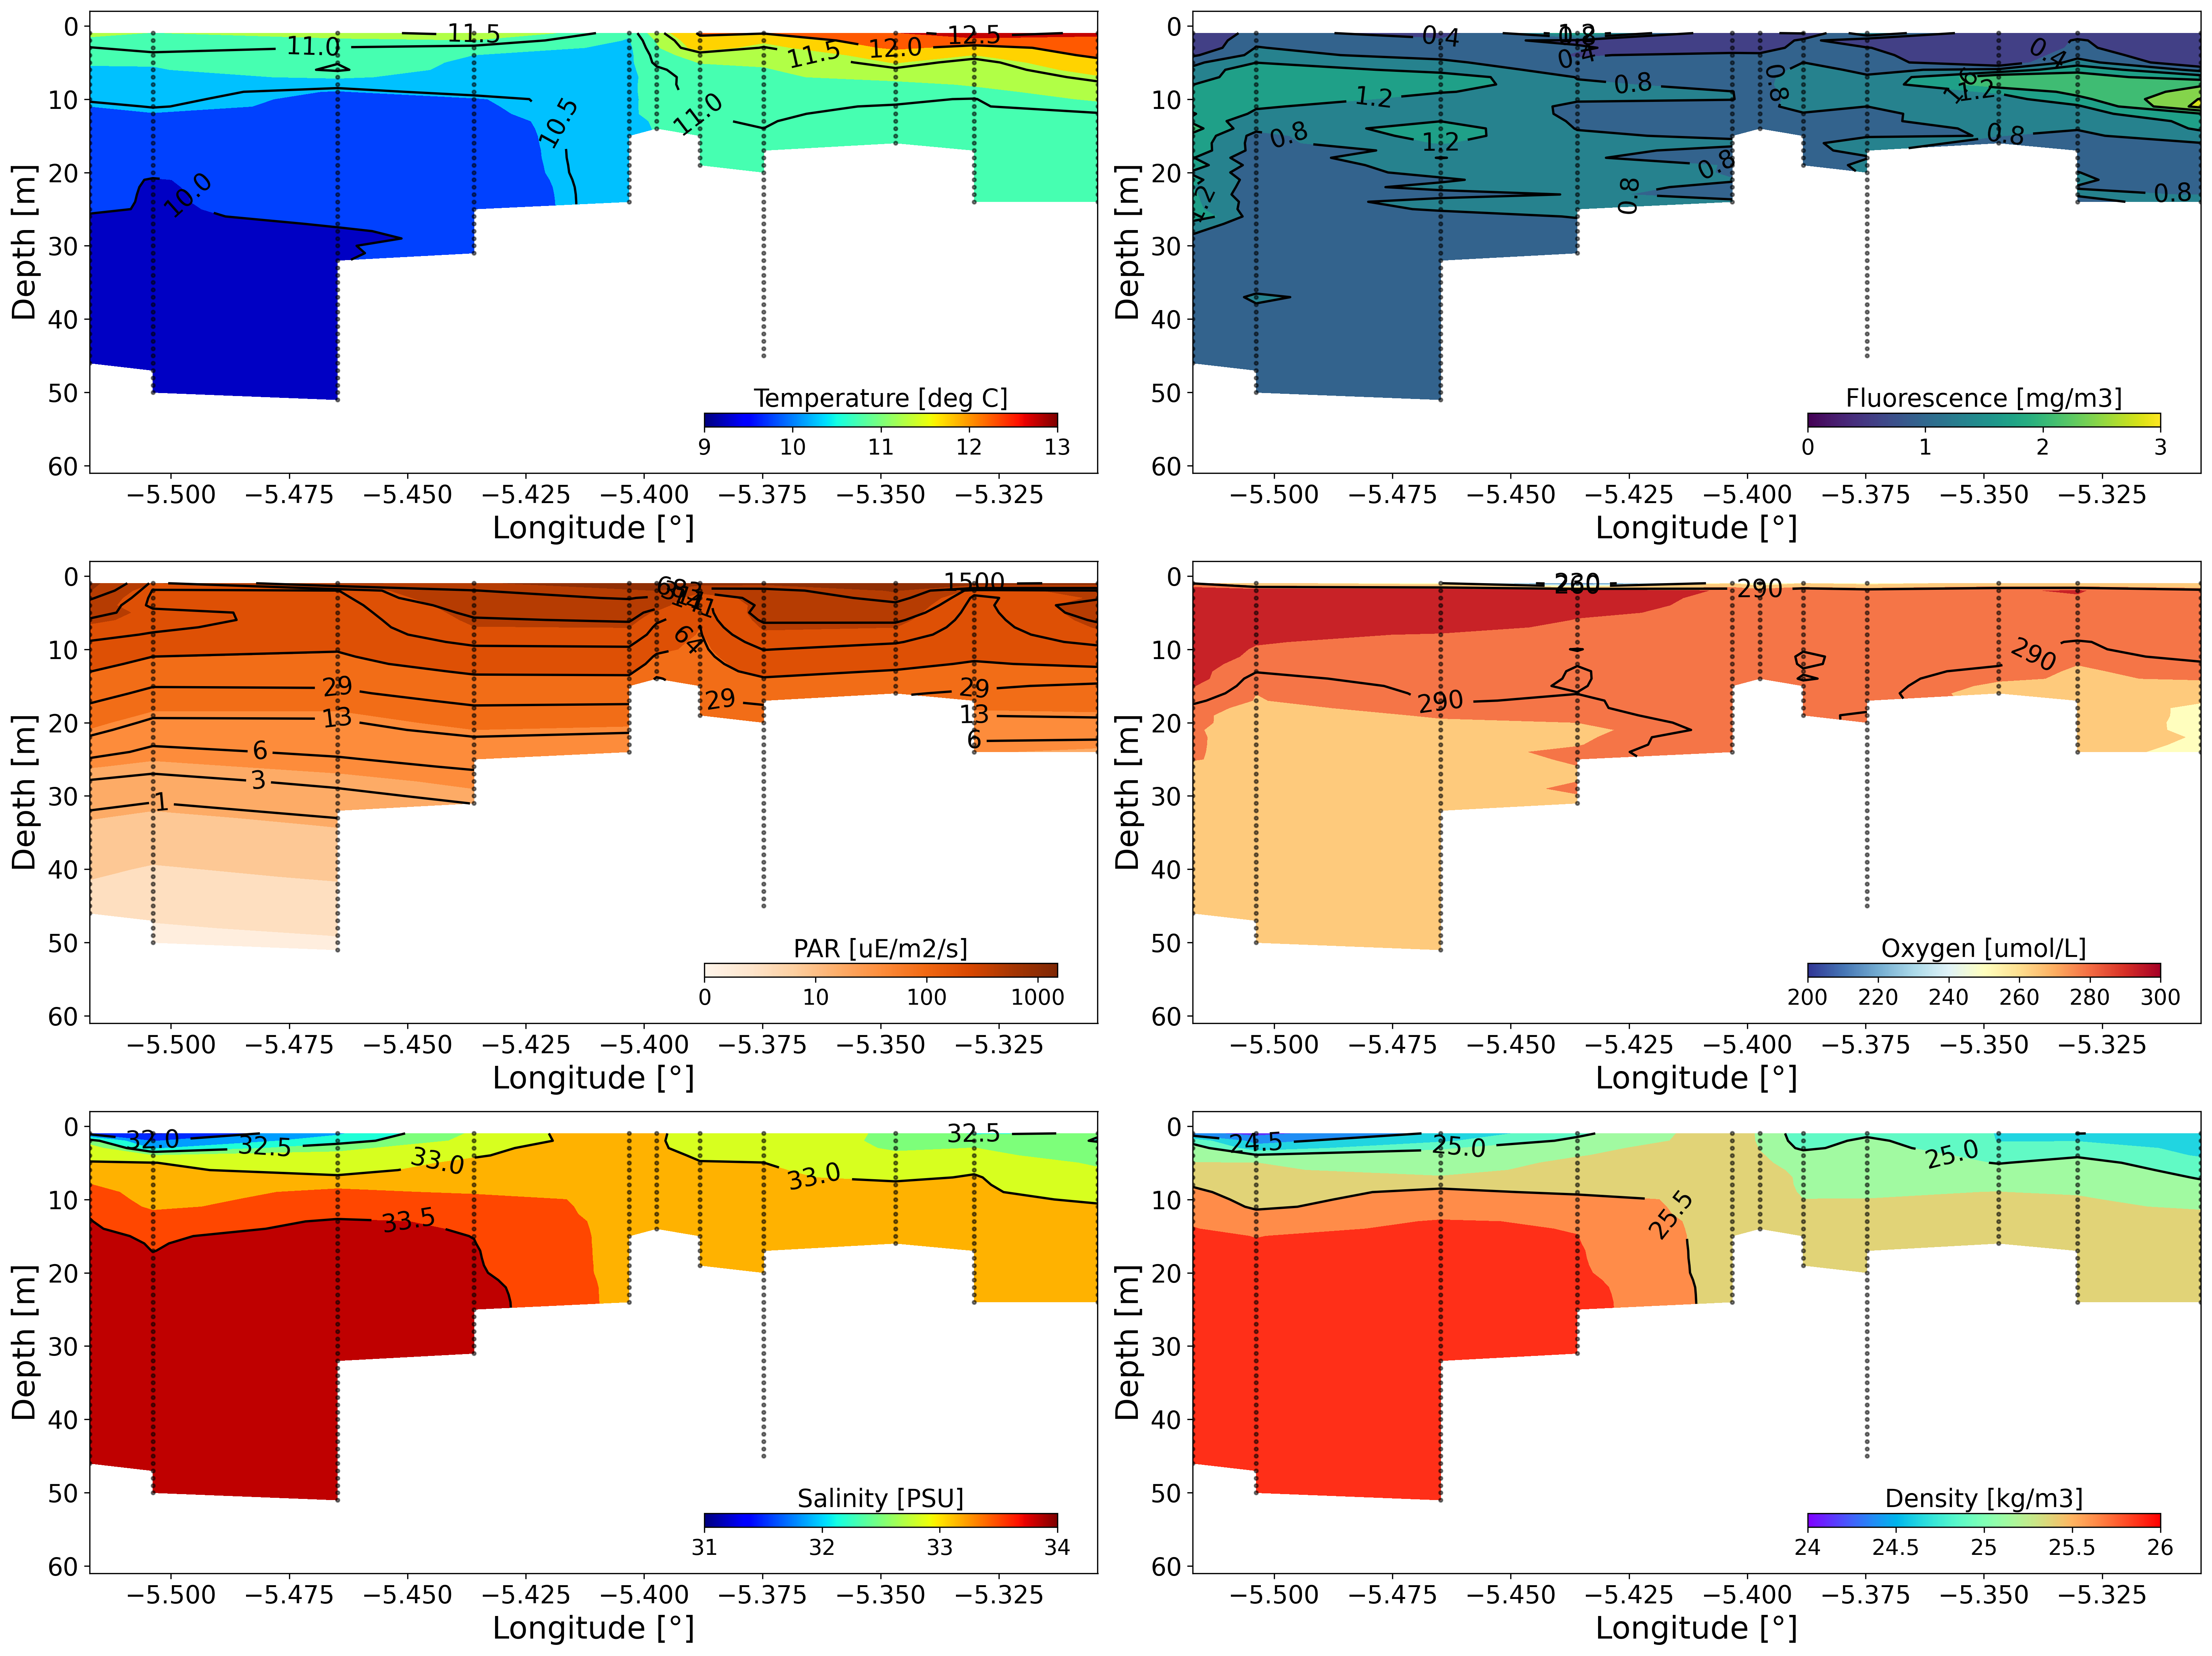

In [10]:
# Set the plot window up
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(20,15),dpi=300)

# temperature
axes[0,0].contourf(X, Y, all_temperature, cmap=cmap_temp)
contour_lines = axes[0,0].contour(X, Y, all_temperature, colors='black', levels=np.arange(9,13,0.5))
for i in range(0,11,1):
    y = all_temperature.iloc[:,i].dropna()
    x = np.matlib.repmat(creran_log_lat_lon['lon_dec'][i], len(y), 1)
    axes[0,0].scatter(x, np.arange(1,len(y)+1), marker='o', c='black', s=5, alpha=0.5)
    
axes[0,0].clabel(contour_lines, inline=True, fontsize=16)
axes[0,0].set_ylim([-2,len(all_temperature)+10])
axes[0,0].invert_yaxis()
axes[0,0].set_xlabel('Longitude [°]', fontsize = 20)
axes[0,0].set_ylabel('Depth [m]', fontsize = 20)
axes[0,0].xaxis.set_tick_params(labelsize=16)
axes[0,0].yaxis.set_tick_params(labelsize=16)

axins = inset_axes(axes[0,0],
                    width="35%",  # width = 50% of parent_bbox width
                    height="3%",  # height : 5%
                    loc='lower right',
                    bbox_to_anchor=(-0.04, 0.1, 1, 1), # based on the right corner (bottom right)
                    bbox_transform=axes[0,0].transAxes,
                    borderpad=0)

cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap_temp, norm=norm_temp), cax=axins, orientation='horizontal',ticks = [9,10,11,12,13])
cb.ax.set_xticklabels(['9','10','11','12','13']) 
cb.set_label(label='Temperature [deg C]', fontsize = 16)
cb.ax.xaxis.set_ticks_position('bottom')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=14)


# fluorescence
axes[0,1].contourf(X, Y, all_fluorescence, cmap=cmap_fluo)
contour_lines = axes[0,1].contour(X, Y, all_fluorescence, colors='black', levels=np.arange(0,3,0.4))
for i in range(0,11,1):
    y = all_temperature.iloc[:,i].dropna()
    x = np.matlib.repmat(creran_log_lat_lon['lon_dec'][i], len(y), 1)
    axes[0,1].scatter(x, np.arange(1,len(y)+1), marker='o', c='black', s=5, alpha=0.5)
    
axes[0,1].clabel(contour_lines, inline=True, fontsize=16)
axes[0,1].set_ylim([-2,len(all_temperature)+10])
axes[0,1].invert_yaxis()
axes[0,1].set_xlabel('Longitude [°]', fontsize = 20)
axes[0,1].set_ylabel('Depth [m]', fontsize = 20)
axes[0,1].xaxis.set_tick_params(labelsize=16)
axes[0,1].yaxis.set_tick_params(labelsize=16)

axins = inset_axes(axes[0,1],
                    width="35%",  # width = 50% of parent_bbox width
                    height="3%",  # height : 5%
                    loc='lower right',
                    bbox_to_anchor=(-0.04, 0.1, 1, 1), # based on the right corner (bottom right)
                    bbox_transform=axes[0,1].transAxes,
                    borderpad=0)

cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap_fluo, norm=norm_fluo), cax=axins, orientation='horizontal',ticks = [0,1,2,3])
cb.ax.set_xticklabels(['0','1','2','3']) 
cb.set_label(label='Fluorescence [mg/m3]', fontsize = 16)
cb.ax.xaxis.set_ticks_position('bottom')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=14)

# PAR
axes[1,0].contourf(X, Y, np.log10(all_par), cmap=cmap_par)
contour_lines = axes[1,0].contour(X, Y, all_par, colors='black', levels=np.logspace(0.1,np.log10(1500),num=10))
for i in range(0,11,1):
    y = all_par.iloc[:,i].dropna()
    x = np.matlib.repmat(creran_log_lat_lon['lon_dec'][i], len(y), 1)
    axes[1,0].scatter(x, np.arange(1,len(y)+1), marker='o', c='black', s=5, alpha=0.5)
    
axes[1,0].clabel(contour_lines, inline=True, fontsize=16)
axes[1,0].set_ylim([-2,len(all_par)+10])
axes[1,0].invert_yaxis()
axes[1,0].set_xlabel('Longitude [°]', fontsize = 20)
axes[1,0].set_ylabel('Depth [m]', fontsize = 20)
axes[1,0].xaxis.set_tick_params(labelsize=16)
axes[1,0].yaxis.set_tick_params(labelsize=16)

axins = inset_axes(axes[1,0],
                    width="35%",  # width = 50% of parent_bbox width
                    height="3%",  # height : 5%
                    loc='lower right',
                    bbox_to_anchor=(-0.04, 0.1, 1, 1), # based on the right corner (bottom right)
                    bbox_transform=axes[1,0].transAxes,
                    borderpad=0)

cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap_par, norm=norm_par), cax=axins, orientation='horizontal',ticks = [0,np.log10(10),np.log10(100),np.log10(1000)])
cb.ax.set_xticklabels(['0','10','100','1000']) 
cb.set_label(label='PAR [uE/m2/s]', fontsize = 16)
cb.ax.xaxis.set_ticks_position('bottom')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=14)

# oxygen
axes[1,1].contourf(X, Y, all_oxygen, cmap=cmap_oxygen)
contour_lines = axes[1,1].contour(X, Y, all_oxygen, colors='black', levels=np.arange(200,300,30))
for i in range(0,11,1):
    y = all_oxygen.iloc[:,i].dropna()
    x = np.matlib.repmat(creran_log_lat_lon['lon_dec'][i], len(y), 1)
    axes[1,1].scatter(x, np.arange(1,len(y)+1), marker='o', c='black', s=5, alpha=0.5)
  
axes[1,1].clabel(contour_lines, inline=True, fontsize=16)
axes[1,1].set_ylim([-2,len(all_oxygen)+10])
axes[1,1].invert_yaxis()
axes[1,1].set_xlabel('Longitude [°]', fontsize = 20)
axes[1,1].set_ylabel('Depth [m]', fontsize = 20)
axes[1,1].xaxis.set_tick_params(labelsize=16)
axes[1,1].yaxis.set_tick_params(labelsize=16)

axins = inset_axes(axes[1,1],
                    width="35%",  # width = 50% of parent_bbox width
                    height="3%",  # height : 5%
                    loc='lower right',
                    bbox_to_anchor=(-0.04, 0.1, 1, 1), # based on the right corner (bottom right)
                    bbox_transform=axes[1,1].transAxes,
                    borderpad=0)

cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap_oxygen, norm=norm_oxygen), cax=axins, orientation='horizontal',ticks = [200,220,240,260,280,300])
cb.ax.set_xticklabels(['200','220','240','260','280','300']) 
cb.set_label(label='Oxygen [umol/L]', fontsize = 16)
cb.ax.xaxis.set_ticks_position('bottom')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=14)

# salinity
axes[2,0].contourf(X, Y, all_salinity, cmap=cmap_sal)
contour_lines = axes[2,0].contour(X, Y, all_salinity, colors='black', levels=np.arange(31,34,0.5))
for i in range(0,11,1):
    y = all_salinity.iloc[:,i].dropna()
    x = np.matlib.repmat(creran_log_lat_lon['lon_dec'][i], len(y), 1)
    axes[2,0].scatter(x, np.arange(1,len(y)+1), marker='o', c='black', s=5, alpha=0.5)
    
axes[2,0].clabel(contour_lines, inline=True, fontsize=16)
axes[2,0].set_ylim([-2,len(all_salinity)+10])
axes[2,0].invert_yaxis()
axes[2,0].set_xlabel('Longitude [°]', fontsize = 20)
axes[2,0].set_ylabel('Depth [m]', fontsize = 20)
axes[2,0].xaxis.set_tick_params(labelsize=16)
axes[2,0].yaxis.set_tick_params(labelsize=16)

axins = inset_axes(axes[2,0],
                    width="35%",  # width = 50% of parent_bbox width
                    height="3%",  # height : 5%
                    loc='lower right',
                    bbox_to_anchor=(-0.04, 0.1, 1, 1), # based on the right corner (bottom right)
                    bbox_transform=axes[2,0].transAxes,
                    borderpad=0)

cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap_sal, norm=norm_sal), cax=axins, orientation='horizontal',ticks = [31,32,33,34])
cb.ax.set_xticklabels(['31','32','33','34']) 
cb.set_label(label='Salinity [PSU]', fontsize = 16)
cb.ax.xaxis.set_ticks_position('bottom')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=14)

# density
axes[2,1].contourf(X, Y, all_density, cmap=cmap_density)
contour_lines = axes[2,1].contour(X, Y, all_density, colors='black', levels=np.arange(24,26,0.5))
for i in range(0,11,1):
    y = all_density.iloc[:,i].dropna()
    x = np.matlib.repmat(creran_log_lat_lon['lon_dec'][i], len(y), 1)
    axes[2,1].scatter(x, np.arange(1,len(y)+1), marker='o', c='black', s=5, alpha=0.5)
    
axes[2,1].clabel(contour_lines, inline=True, fontsize=16)
axes[2,1].set_ylim([-2,len(all_density)+10])
axes[2,1].invert_yaxis()
axes[2,1].set_xlabel('Longitude [°]', fontsize = 20)
axes[2,1].set_ylabel('Depth [m]', fontsize = 20)
axes[2,1].xaxis.set_tick_params(labelsize=16)
axes[2,1].yaxis.set_tick_params(labelsize=16)

axins = inset_axes(axes[2,1],
                    width="35%",  # width = 50% of parent_bbox width
                    height="3%",  # height : 5%
                    loc='lower right',
                    bbox_to_anchor=(-0.04, 0.1, 1, 1), # based on the right corner (bottom right)
                    bbox_transform=axes[2,1].transAxes,
                    borderpad=0)

cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap_density, norm=norm_density), cax=axins, orientation='horizontal',ticks = [24,24.5,25,25.5,26])
cb.ax.set_xticklabels(['24','24.5','25','25.5','26']) 
cb.set_label(label='Density [kg/m3]', fontsize = 16)
cb.ax.xaxis.set_ticks_position('bottom')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=14)

fig.tight_layout()

#IF YOU WANT TO SAVE THE IMAGE TO YOUR FOLDER UNCOMMENT THIS LINE
#fig.savefig('plot_contour', dpi = 300)